# Malaysia Crime Analysis and Prediction

#### <u>Problem Statement</u>
Malaysia is a country with a notably high crime rate, especially in its urban centers. Urban centers like Kuala Lumpur, Penang and Johor Bahru face significant levels of theft, burglary and violent crimes. There is a pressing need for targeted crime prevention strategies and efficient resource allocation. Additionally, the lack of predictive crime prevention suggests that the current systems often react to crimes rather than predicting them. This limitation makes it challenging to pinpoint potential crime hotspots or times requiring increased vigilance. This could lead to police and other law enforcement agencies often deploy resources inefficiently due to the lack of actionable insights.

#### <u>Overview</u>
The objective of this notebook is to analyze and predict crime patterns based on collected data. The challenge at hand is approached as a regression problem, where the target variable is the number of crimes reported ("crimes"). By utilizing the model developed in this notebook, the number of crimes can be predicted based on features such as state, district, category, type, and date. These predictions will help identify trends over time and regions, enabling law enforcement to anticipate areas with a higher likelihood of criminal activity. By leveraging these insights, resources can be allocated more effectively, patrols can be optimized in high-risk areas, and strategies for crime prevention can be improved, ultimately enhancing public safety.

#### <u>Data Collection</u>
The dataset is obtained from [data.gov.my](https://data.gov.my/data-catalogue/crime_district) which consist of the number of crimes in Malaysia by district, crime category, and type of crime. The data is collected by the Police Reporting System administered by the Royal Malaysian Police. To run the code locally, you could access the github repository link below and look under `README.md` file for the compilation instructions.


### Table Of Contents
- 1. Install & Import Libraries
- 2. Exploring the data
- 3. Data Preprocessing
  - 3.1 Handling Missing Values
  - 3.2 Handling Duplicated Values
  - 3.3 Parsing Dates
  - 3.4 Feature Engineering
  - 3.5 Drop unecessary columns
- 4. Data Visualization
  - 4.1 Pearson Correlation Heatmap
  - 4.2 Univariate Analysis
  - 4.3 Bivariate Analysis
- 5. Data Mining
  - 5.1 Label Encoding
  - 5.2 One-Hot Encoding
  - 5.3 Target Encoding
- 6. Modeling
  - 6.1 Feature Scaling
  - 6.2 Baseline Models
  - 6.3 Hyperparameter Tuning
  - 6.4 Rebuilding Models with Tuned parameters
- 7. PCA
  - 7.1 Data Visualization using PCA
  - 7.2 Model Training using PCA
- 8. Model Evaluations and Predictions
  - 8.1 Model Evaluations
  - 8.2 Learning Curves
  - 8.3 Feature Importance
  - 8.4 Model Predictions
- 9. Conclusion
- 10. References

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1.0 Install & Import libraries <a class="anchor" id="h1"></a>

Install the package below in order to import the library

In [3]:
# !pip uninstall category_encoders
# !pip install pandas==2.2.3
#!pip install scikit-learn==1.5.0
# !pip install category_encoders==2.6.4
# !pip install catboost
# !pip install shap

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from xgboost import XGBRegressor
import xgboost as xgb
import catboost
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import ShuffleSplit, learning_curve

from sklearn.decomposition import PCA

import shap

## 2.0 Exploring the data

We will start by loading the dataset.

In [32]:
# Read the CSV file
# Run the below code if you are working in google colab
# df = pd.read_csv('/content/drive/MyDrive/ml assignment/crime_district.csv')

# Run the below code if you are working in a local directory
df = pd.read_csv('crime_district.csv')
df.head()

state district category type        date  crimes
0  Malaysia      All  assault  all  2016-01-01   22327
1  Malaysia      All  assault  all  2017-01-01   21366
2  Malaysia      All  assault  all  2018-01-01   16902
3  Malaysia      All  assault  all  2019-01-01   16489
4  Malaysia      All  assault  all  2020-01-01   13279

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19152 entries, 0 to 19151
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   state     19152 non-null  object
 1   district  19152 non-null  object
 2   category  19152 non-null  object
 3   type      19152 non-null  object
 4   date      19152 non-null  object
 5   crimes    19152 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 897.9+ KB


As we notice, all of the columns in the dataset are mostly in object datatype, we will have to encode them before passing in to the model. Meanwhile, our target variable, `crimes`, is of numerical datatype.

In [34]:
df.shape

(19152, 6)

There are 19152 rows and 6 columns within the dataset.

In [35]:
df.describe()

crimes
count  19152.000000
mean     189.728018
std     1590.813293
min        0.000000
25%        1.000000
50%       12.000000
75%       66.000000
max    90028.000000

## 3.0 Data Preprocessing
### 3.1 Handling Missing Values

Next, we will need to handle the missing values in the dataframe.

In [36]:
df.isnull().sum()

state       0
district    0
category    0
type        0
date        0
crimes      0
dtype: int64

We can observe that there is no missing values so we do not need to perform any action.

### 3.2 Handling Duplicated Values
Following on, we will check if there is any duplicated values found in dataframe.

In [37]:
duplicate_data = df.duplicated()
df[duplicate_data]

Empty DataFrame
Columns: [state, district, category, type, date, crimes]
Index: []

We can observe that there is no duplicated data found, which is good.

### 3.3 Parsing Dates

Notice that the date column is of type object, we have to correct it to date format

In [38]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

state               object
district            object
category            object
type                object
date        datetime64[ns]
crimes               int64
dtype: object

### 3.4 Feature Engineering
We will manually engineer some additional features out of the original dataset, the *date* column provides information such as day, month and year which could be beneficial for our model, we will split it into 3 columns and drop the original *date* column since its not of used anymore.

In [39]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

df.drop(columns=['date'], inplace=True)
df.head()

state district category type  crimes  day  month  year
0  Malaysia      All  assault  all   22327    1      1  2016
1  Malaysia      All  assault  all   21366    1      1  2017
2  Malaysia      All  assault  all   16902    1      1  2018
3  Malaysia      All  assault  all   16489    1      1  2019
4  Malaysia      All  assault  all   13279    1      1  2020

Notice that it creates 3 additional columns, *day*, *month* and *year*

### 3.5 Drop unecessary columns

There are some columns that can be removed to avoid redundancy. Let's start by looking at the unique values in the data frame.

In [40]:
df.nunique()

state         15
district     160
category       2
type          13
crimes      1341
day            1
month          1
year           8
dtype: int64

Based on the observed unique values in the dataframe, we can identify the column `day` and `month` has only 1 unique value, so it can be eliminated as it adds no additional information

In [41]:
df.drop(['day', 'month'], axis=1, inplace=True)
df.columns

Index(['state', 'district', 'category', 'type', 'crimes', 'year'], dtype='object')

## 4.0 Data Visualization

### 4.1 Pearson Correlation Heatmap

Next, we would plot a quick correlational analysis to examine the relationship between the numerical attributes by utilizing a seaborn heatmap.

<Axes: >

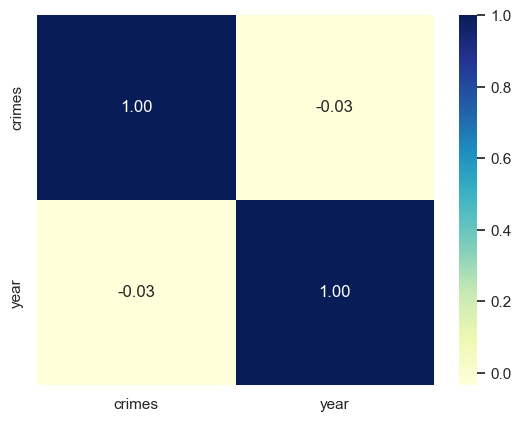

In [42]:
cor = df.corr(numeric_only=True)
sns.heatmap(cor, annot=True, fmt=".2f", cmap='YlGnBu')

The heatmap reveals a low correlation of -0.03 between crimes and year, indicating a slight negative linear relationship. This suggests that as the years progress, the number of crimes tends to decrease.

### 4.2 Univariate Analysis


Next, we would plot the univariate analysis to understand the data distribution for each of the features. We would first start off by visualizing the distribution for categorical variables with a bar chart.

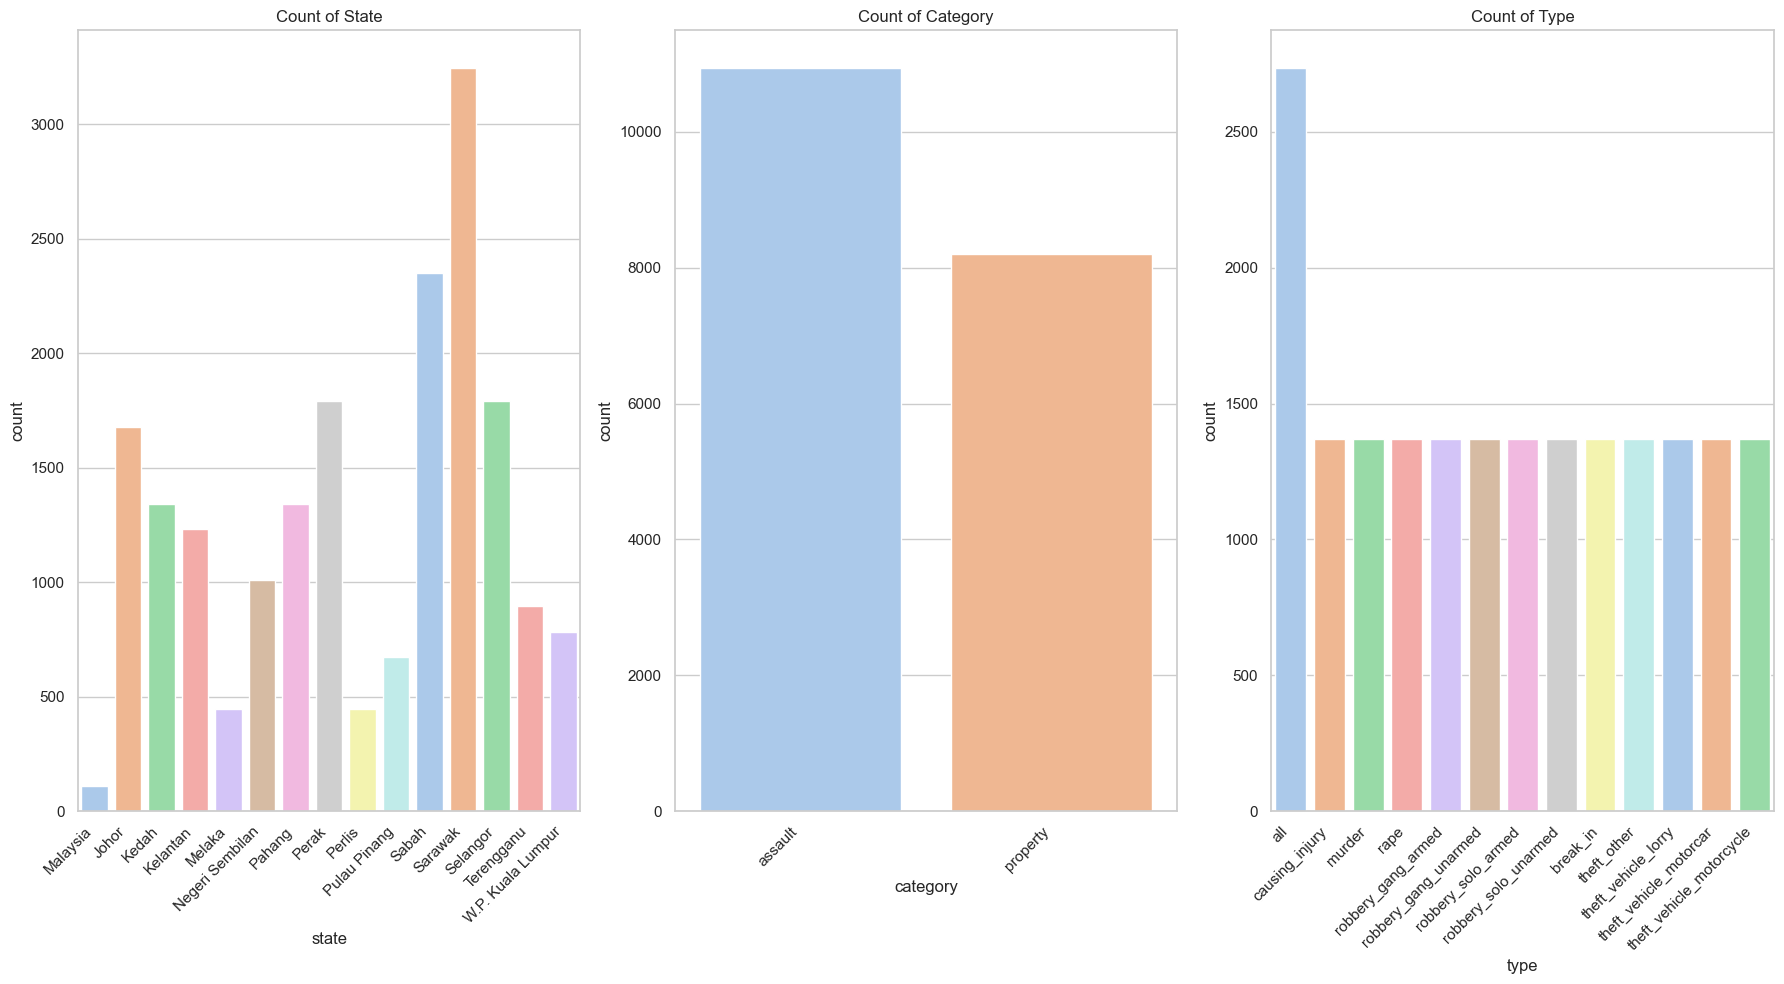

In [43]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 10))

categorical_columns = ['state', 'category', 'type']
for i, col in enumerate(categorical_columns):
    ax = axes[i]
    sns.countplot(data=df, x=col, ax=ax, palette="pastel", hue=col, legend=False)
    ax.set_title(f"Count of {col.capitalize()}")
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()

From the visualizations above, we notice that:
1. Sarawak stands out as the state with the highest number of occurrences.
2. Among the crime categories, assault is the most prevalent.
3. For crime types, all categories exhibit similar counts, except for the "all" type, which significantly exceeds the others.

Next, we will plot a KDE(Kernel Density) plot to visualize the distribution for the numerical attributes.

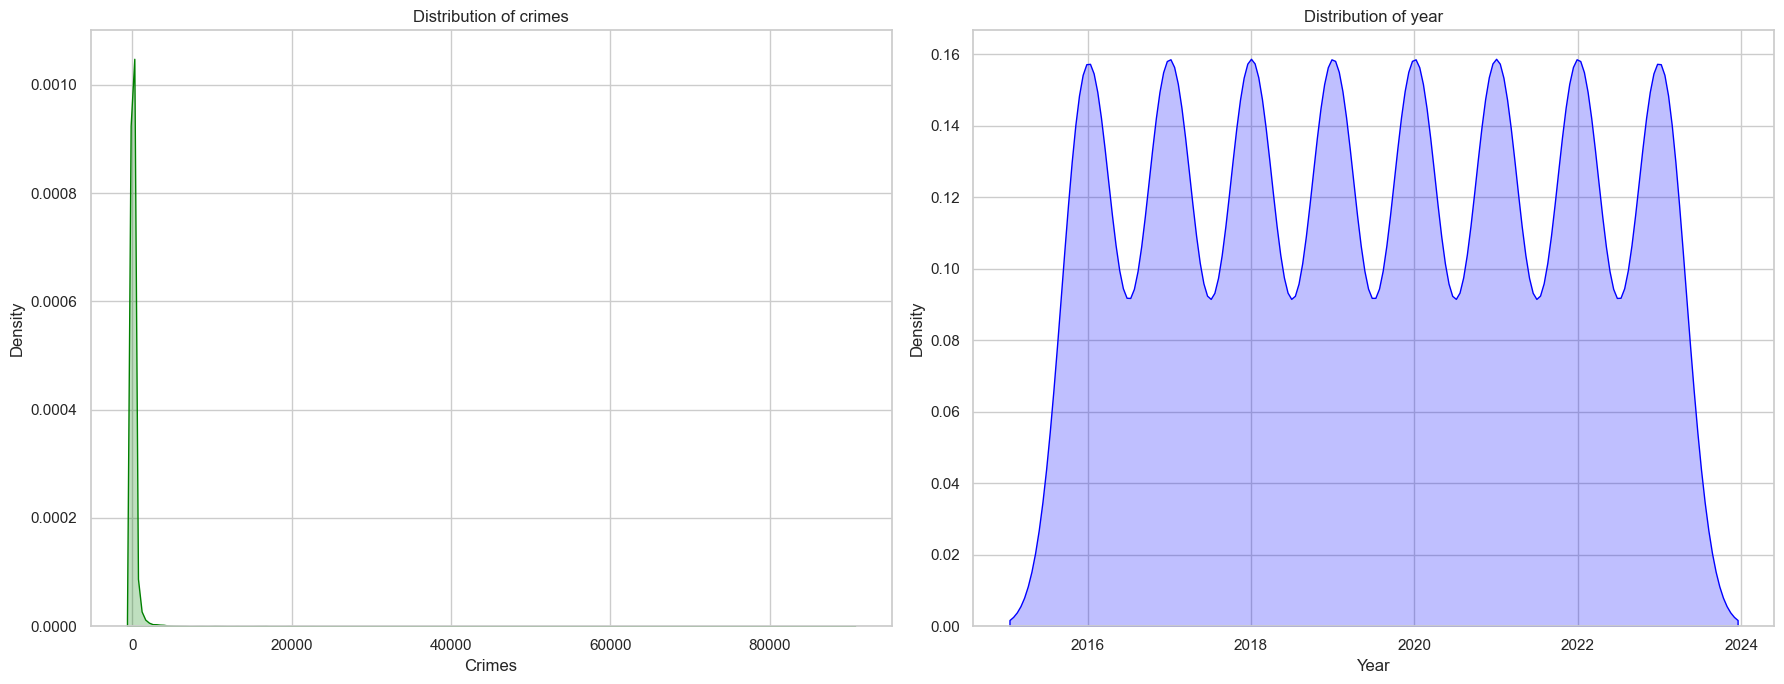

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
ax = ax.flatten()

# Variables for KDE plot (selecting only numerical variables)
variables = df.select_dtypes(include=['int64', 'int32']).columns

colors = ['green', 'blue']

# Loop through variables and axes to create the KDE plots
for i, (variable, color) in enumerate(zip(variables, colors)):
    ax[i].set_title(f'Distribution of {variable}')
    sns.kdeplot(df[variable], fill=True, color=color, ax=ax[i])
    ax[i].set_xlabel(variable.capitalize())
    ax[i].set_ylabel("Density")

plt.tight_layout()
plt.show()

From the visualizations above, we notice that:
1. The distribution of crimes is highly skewed to the right, with most values concentrated near 0.
2. The year distribution shows a periodic pattern, with peaks occurring at regular intervals.

### 4.3 Bivariate Analysis

Next, we will conduct a bivariate analysis to explore the correlation between two attributes.

We would first start off by visualizing the total crimes committed for each of the categorical variables using a bar chart. For the state column, we excluded "Malaysia" as it represents national-level aggregated data, ensuring the focus remains on individual states, meanwhile for the type column, we excluded "all" as it represents the aggregated total of all crime types, rather than a specific category. This ensures that our visualizations accurately reflect the breakdown of crimes by individual types and states, providing more granular insights into the data.

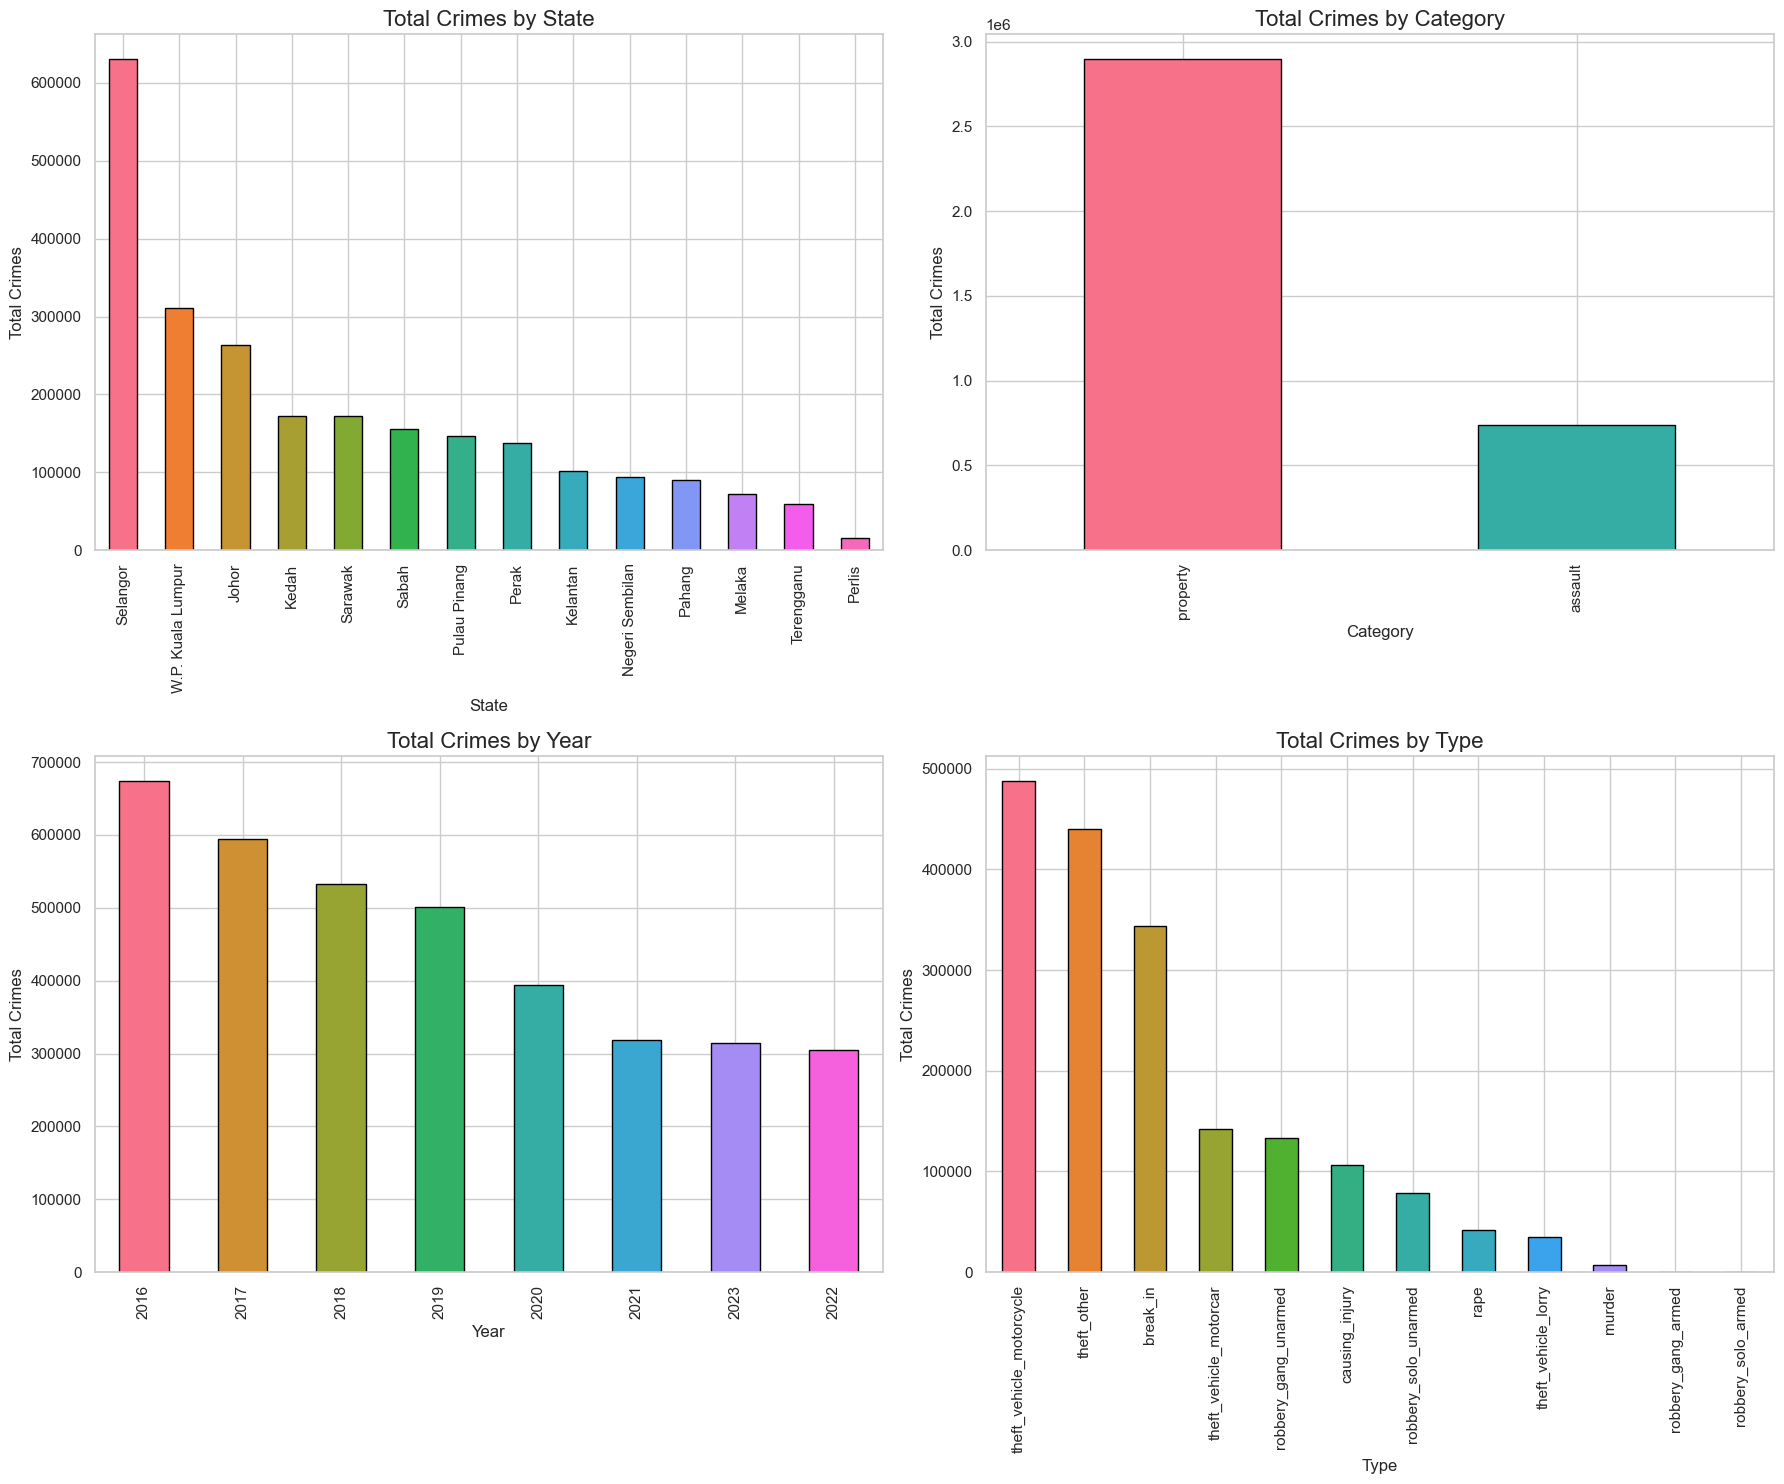

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(18, 15))

categorical_columns = ['state', 'category', 'year', 'type']
for i, col in enumerate(categorical_columns):
    ax = axes[i // 2, i % 2]
    crime_type_totals = df.groupby(col)['crimes'].sum().sort_values(ascending=False)
    # if column is state, excludes Malaysia as it represents national-level aggregated data
    if col == 'state':
        crime_type_totals = df[df['state'] != 'Malaysia'].groupby(col)['crimes'].sum().sort_values(ascending=False)
    if col == 'type':
        crime_type_totals = df[df['type'] != 'all'].groupby(col)['crimes'].sum().sort_values(ascending=False)

    # Bar chart for crime types
    colors = sns.color_palette('husl', len(crime_type_totals))
    crime_type_totals.plot(
        kind='bar',
        color=colors,
        edgecolor='black',
        ax=ax
    )
    ax.set_title(f'Total Crimes by {col.title()}', fontsize=16)
    ax.set_xlabel(col.title(), fontsize=12)
    ax.set_ylabel('Total Crimes', fontsize=12)
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


From the visualization above, we could observe that:
1. Selangor committed the most crimes compare to the other states, followed by Kuala Lumpur as the second, and Perlis the last. This suggests that  urbanized areas like Selangor and Kuala Lumpur are more prone to higher crime rates, possibly due to greater economic activity and population density.
   
2. Property crimes dominate as the most prevalent category, vastly outnumbering assaults. This indicates that crimes involving theft, burglary, or vandalism are far more common than those involving direct physical harm to individuals.
   
3. The year 2016 stands out as having the highest number of reported crimes. However, there is a noticeable downward trend in crime rates over the subsequent years.

4. Among the various types of crimes, motorcycle theft is the most frequently reported, followed by other unspecified thefts. This trend underscores the vulnerability of motorcycles as targets for theft, particularly in urban areas where motorcycles are commonly used for transportation.

This can be further proven by visualizing a pie chart illustrating the total crime percentage of each state and type of crimes committed across Malaysia.

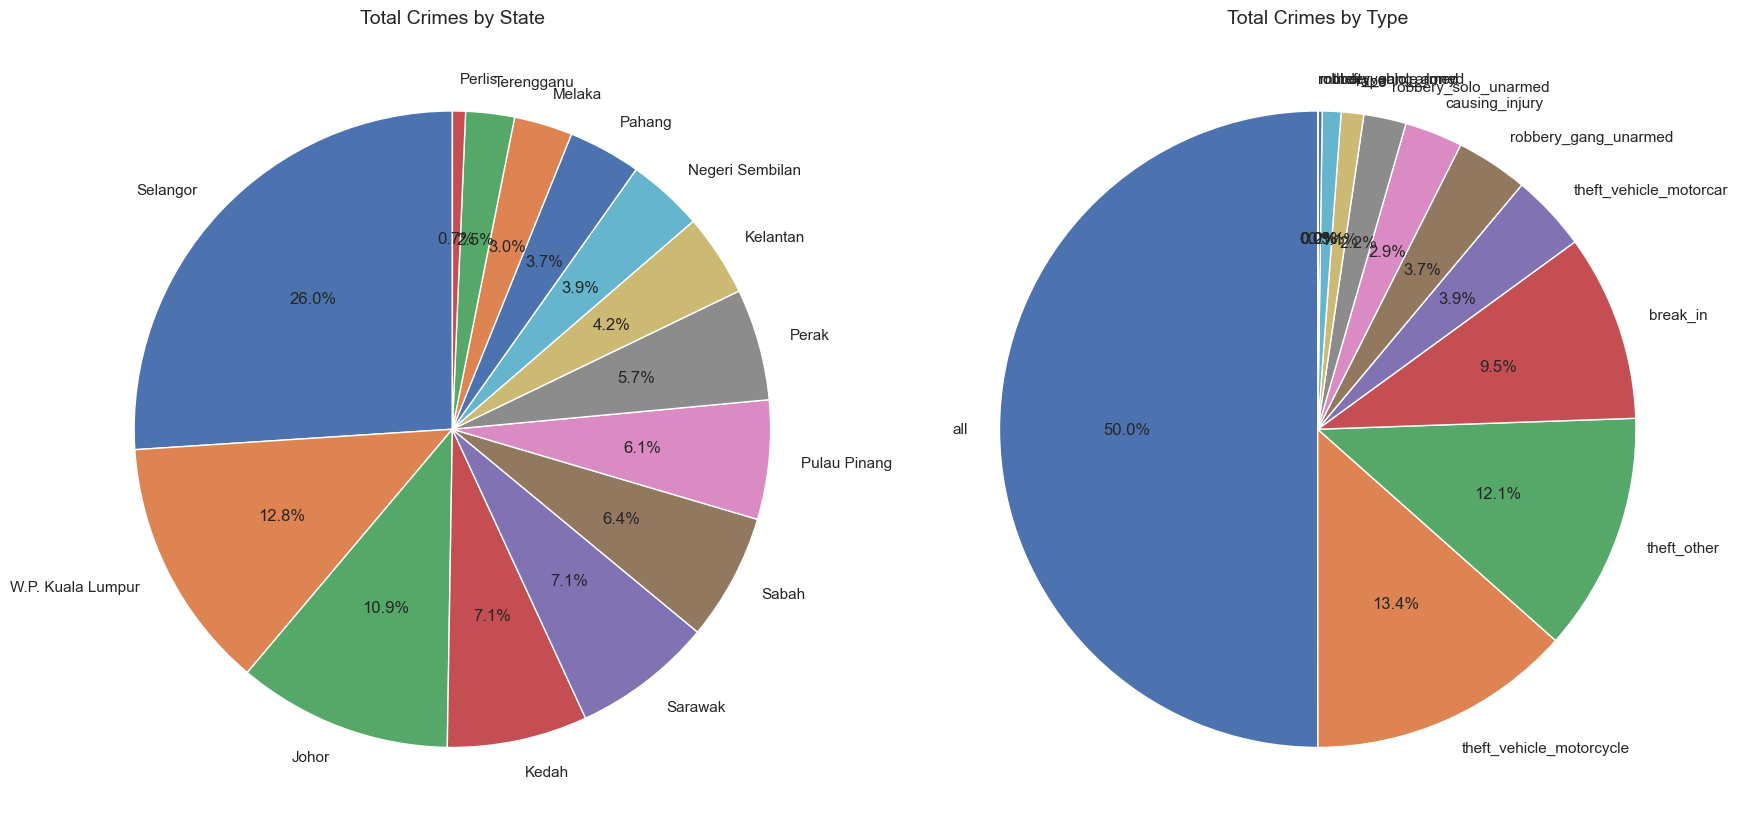

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(18, 15))

categorical_columns = ['state', 'type']
for i, col in enumerate(categorical_columns):
    ax = axes[i]
    crime_totals = df.groupby(col)['crimes'].sum().sort_values(ascending=False)

    # Exclude 'Malaysia' for 'state'
    if col == 'state':
        crime_totals = df[df['state'] != 'Malaysia'].groupby(col)['crimes'].sum().sort_values(ascending=False)

    crime_totals.plot(
        kind='pie',
        color=colors,
        autopct='%1.1f%%',
        startangle=90,
        ax=ax,
        legend=False
    )
    ax.set_title(f'Total Crimes by {col.capitalize()}', fontsize=14)
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


From the pie chart above, we notice that:
1. Selangor has the most number of crimes committed by 26%, followed by Kuala Lumpur as the second
2. The most number of type committed is all, which took about half of all the crimes committed


Next, we group the data by specific columns to analyze the relationships between each variable, visualizing the results using horizontal bar charts. Let's first start off by looking into the question, `What is the most frequently committed crime in each state of Malaysia?`, same as before, we would exclude "Malaysia" as it represents national-level aggregated data

In [47]:
filtered_df = df[df['state'] != 'Malaysia']

# Aggregate crimes by state and type
state_type_totals = filtered_df[filtered_df['type'] != 'all'].groupby(['state', 'type'])['crimes'].sum()

# Find the most committed crime type for each state
most_common_crimes = state_type_totals.groupby('state').idxmax()
most_common_counts = state_type_totals.groupby('state').max()

result_df = pd.DataFrame({
    'State': [item[0] for item in most_common_crimes],
    'Most Common Crime Type': [item[1] for item in most_common_crimes],
    'Total Crimes': most_common_counts.values
})

print(result_df)

                State    Most Common Crime Type  Total Crimes
0               Johor  theft_vehicle_motorcycle         44204
1               Kedah  theft_vehicle_motorcycle         30502
2            Kelantan  theft_vehicle_motorcycle         17880
3              Melaka  theft_vehicle_motorcycle         10428
4     Negeri Sembilan               theft_other         13388
5              Pahang               theft_other         12586
6               Perak  theft_vehicle_motorcycle         19608
7              Perlis               theft_other          2788
8        Pulau Pinang  theft_vehicle_motorcycle         23552
9               Sabah               theft_other         32830
10            Sarawak               theft_other         24952
11           Selangor  theft_vehicle_motorcycle         83116
12         Terengganu               theft_other          8442
13  W.P. Kuala Lumpur               theft_other         41390


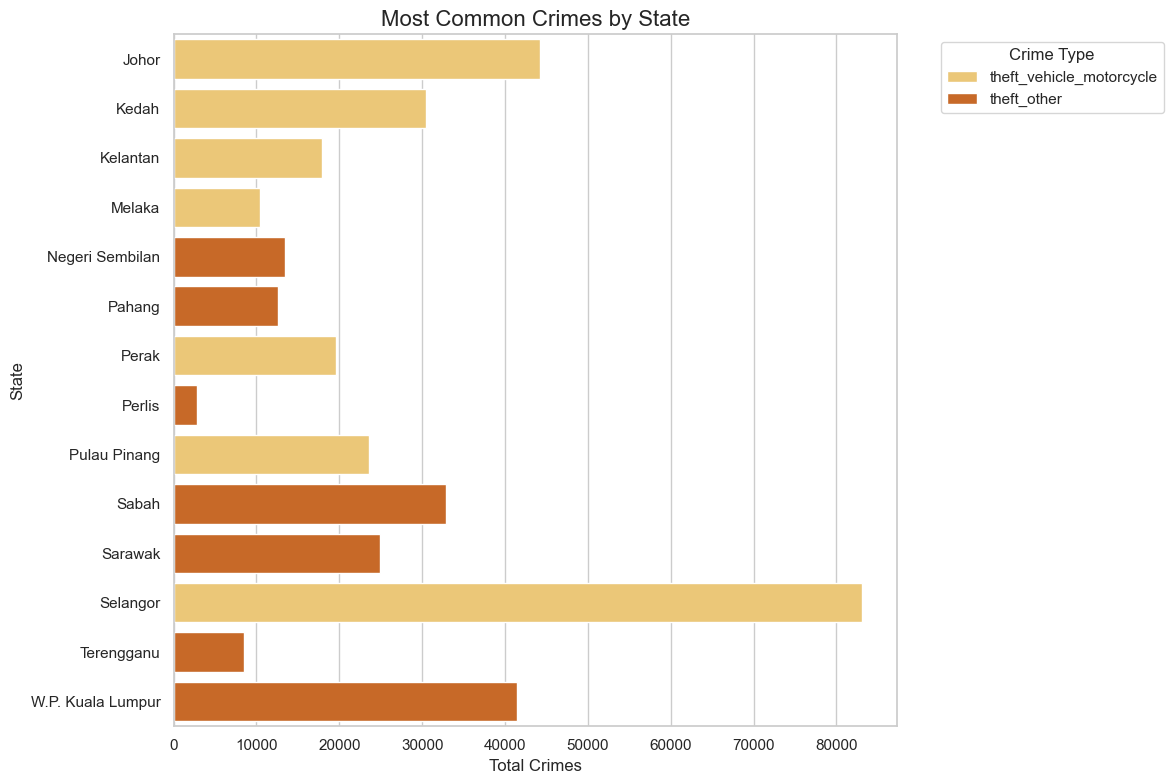

In [48]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=result_df,
    y='State',
    x='Total Crimes',
    hue='Most Common Crime Type',
    dodge=False,
    palette='YlOrBr'
)

# Add titles and labels
plt.title('Most Common Crimes by State', fontsize=16)
plt.xlabel('Total Crimes', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.legend(title='Crime Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend on the side
plt.tight_layout()
plt.show()

Based on the bar chart above, we can conclude that "theft_vehicle_motorcycle" and "theft_other" are the primary crime types in Malaysia. Selangor has the highest total crimes, dominated by "theft_vehicle_motorcycle" while states like Sabah and Kuala Lumpur see a significant contribution from "theft_other."

Following on, let's into the question: `Which state has the most number of crimes committed in each year?`, we will plot a scatterplot for this.

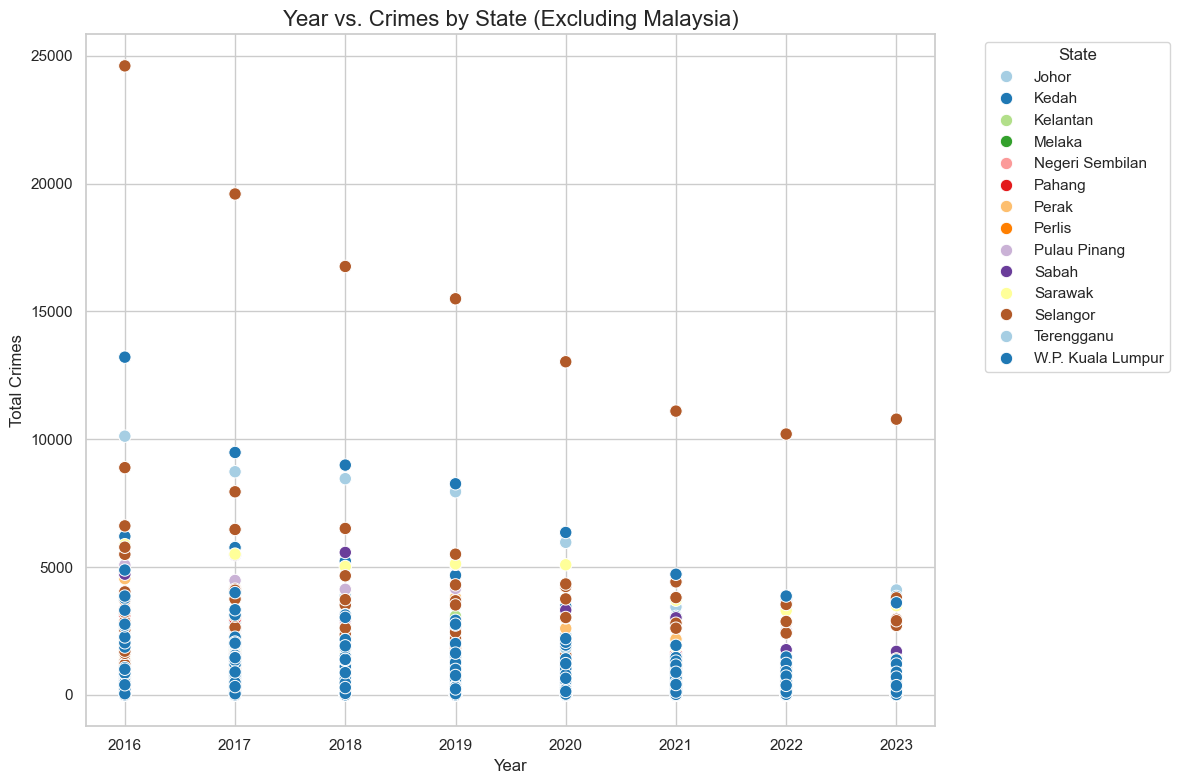

In [49]:
filtered_df = df[df['state'] != 'Malaysia']

# Scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='year', y='crimes', hue='state', data=filtered_df, palette='Paired', s=80)
plt.title('Year vs. Crimes by State (Excluding Malaysia)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Crimes', fontsize=12)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Based on the plot above, Selangor dominates as the highest number of crimes committed in each year.

## 5.0 Data Mining

### Encode Categorical Columns

Next, we will look into how we could encode the categorical features, lets first observe how many unique values are in each of the categorical columns.

In [50]:
df.select_dtypes(include=['object']).nunique()

state        15
district    160
category      2
type         13
dtype: int64

There are typically two approaches to handling categorical variables:

- Label Encoding: This method assigns unique integer values to each category. It is generally used when a column has fewer than 3 unique categories. In our case, we could encode the category into two labels.

- One-Hot Encoding: This method is applied when there are more than 3 unique categories. It creates separate columns for each category. For instance, we could encode attributes like state and type into distinct columns.

Note here that we will not be encoding *district* as there are 160 unique values which might create lots of columns and can be resource intensive

### 5.1 Label Encoding

We will start off with encode *category* column with label encoder. Notice that after transforming it contains 2 values which are 0 and 1.

In [51]:
le = LabelEncoder()
df['category']= le.fit_transform(df['category'])
df['category'].unique()

array([0, 1])

### 5.2 One-Hot Encoding
Next, we will transform categorical features into numerical columns. We will start off with applying one-hot encoding to transform each unique value in the  *type* column into a distinct binary feature. This process converts categorical data into a numerical format, allowing machine learning models to interpret and utilize the information effectively.

In [52]:
df.nunique()

state         15
district     160
category       2
type          13
crimes      1341
year           8
dtype: int64

In [53]:
# Break Down the `type` Column
types = df['type'].unique()  # Get all unique crime types
print(types)

['all' 'causing_injury' 'murder' 'rape' 'robbery_gang_armed'
 'robbery_gang_unarmed' 'robbery_solo_armed' 'robbery_solo_unarmed'
 'break_in' 'theft_other' 'theft_vehicle_lorry' 'theft_vehicle_motorcar'
 'theft_vehicle_motorcycle']


In [54]:
df = pd.get_dummies(df, columns=['type'], prefix='type')
df.head()

state district  category  crimes  year  type_all  type_break_in  \
0  Malaysia      All         0   22327  2016      True          False   
1  Malaysia      All         0   21366  2017      True          False   
2  Malaysia      All         0   16902  2018      True          False   
3  Malaysia      All         0   16489  2019      True          False   
4  Malaysia      All         0   13279  2020      True          False   

   type_causing_injury  type_murder  type_rape  type_robbery_gang_armed  \
0                False        False      False                    False   
1                False        False      False                    False   
2                False        False      False                    False   
3                False        False      False                    False   
4                False        False      False                    False   

   type_robbery_gang_unarmed  type_robbery_solo_armed  \
0                      False                    False   
1                      False                    False   
2                      False                    False   
3                      False                    False   
4                      False                    False   

   type_robbery_solo_unarmed  type_theft_other  type_theft_vehicle_lorry  \
0                      False             False                     False   
1                      False             False                     False   
2                      False             False                     False   
3                      False             False                     False   
4                      False             False                     False   

   type_theft_vehicle_motorcar  type_theft_vehicle_motorcycle  
0                        False                          False  
1                        False                          False  
2                        False                          False  
3                        False                          False  
4                        False                          False

We can observe that it creates 12 new columns for each of the category in *type* column. Next, we will apply one-hot encoding to transform each unique value in the state column into a distinct binary feature.

In [55]:
df = pd.get_dummies(df, columns=['state'], prefix='state')
df.head()

district  category  crimes  year  type_all  type_break_in  \
0      All         0   22327  2016      True          False   
1      All         0   21366  2017      True          False   
2      All         0   16902  2018      True          False   
3      All         0   16489  2019      True          False   
4      All         0   13279  2020      True          False   

   type_causing_injury  type_murder  type_rape  type_robbery_gang_armed  ...  \
0                False        False      False                    False  ...   
1                False        False      False                    False  ...   
2                False        False      False                    False  ...   
3                False        False      False                    False  ...   
4                False        False      False                    False  ...   

   state_Negeri Sembilan  state_Pahang  state_Perak  state_Perlis  \
0                  False         False        False         False   
1                  False         False        False         False   
2                  False         False        False         False   
3                  False         False        False         False   
4                  False         False        False         False   

   state_Pulau Pinang  state_Sabah  state_Sarawak  state_Selangor  \
0               False        False          False           False   
1               False        False          False           False   
2               False        False          False           False   
3               False        False          False           False   
4               False        False          False           False   

   state_Terengganu  state_W.P. Kuala Lumpur  
0             False                    False  
1             False                    False  
2             False                    False  
3             False                    False  
4             False                    False  

[5 rows x 32 columns]

We can observe that it creates 15 new columns for each of the category in *state* column.

### 5.3 Target Encoding

Due to district having 160 unique values, using one hot encoding would lead to increased dimensionality that would cause slower computation. Hence we will perform target encoding on the 'district' column. It works by encoding the district categories based on the target variable (average value of the target for each district)

In [56]:
# Initialize TargetEncoder
target_encoder = ce.TargetEncoder(cols=['district'])

# Fit and transform the district column
df['district_encoded'] = target_encoder.fit_transform(df['district'], df['crimes'])

# shift column 'Name' to first position
first_column = df.pop('district_encoded')

# insert column using insert(position,column_name,
# first_column) function
df.insert(0, 'district_encoded', first_column)

df = df.drop(columns=['district'])

# Display the result
df.head()


district_encoded  category  crimes  year  type_all  type_break_in  \
0       1441.659524         0   22327  2016      True          False   
1       1441.659524         0   21366  2017      True          False   
2       1441.659524         0   16902  2018      True          False   
3       1441.659524         0   16489  2019      True          False   
4       1441.659524         0   13279  2020      True          False   

   type_causing_injury  type_murder  type_rape  type_robbery_gang_armed  ...  \
0                False        False      False                    False  ...   
1                False        False      False                    False  ...   
2                False        False      False                    False  ...   
3                False        False      False                    False  ...   
4                False        False      False                    False  ...   

   state_Negeri Sembilan  state_Pahang  state_Perak  state_Perlis  \
0                  False         False        False         False   
1                  False         False        False         False   
2                  False         False        False         False   
3                  False         False        False         False   
4                  False         False        False         False   

   state_Pulau Pinang  state_Sabah  state_Sarawak  state_Selangor  \
0               False        False          False           False   
1               False        False          False           False   
2               False        False          False           False   
3               False        False          False           False   
4               False        False          False           False   

   state_Terengganu  state_W.P. Kuala Lumpur  
0             False                    False  
1             False                    False  
2             False                    False  
3             False                    False  
4             False                    False  

[5 rows x 32 columns]

In [57]:
df.shape

(19152, 32)

There are 32 columns now.

## 6.0 Modeling

### 6.1 Feature Scaling


Feature scaling is the process of normalizing or standardizing the range of features (input variables) in a dataset. It ensures that all features contribute equally to the model's predictions, particularly for algorithms sensitive to the magnitude of the features. Since we are using algorithms that are sensitive to feature scaling such as KNN, SVR, and neural networks, it is recommended to scale the features first.

In [58]:
X = df.drop(columns=['crimes'])
y = df['crimes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Number of samples in training set: {X_train.shape[0]}")
print(f"Number of samples in test set: {X_test.shape[0]}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Number of samples in training set: 15321
Number of samples in test set: 3831


The result shows the number of samples after train test split, we split to a 80% training and 20% testing.

### 6.2 Baseline Models

We will begin by creating baseline regression models using their default parameters. We will be using 9 different type of models, namely Linear Regression, Random Forest Regressor, K Neighbors Regressor, CatBoost Regressor, Gradient Boosting Regressor, XGB Regressor, LGBM Regressor, Support Vector Regression(SVR) and Decision Tree Regressor. After that, we will select the top three models with the highest performance and proceed with hyperparameter tuning. The following metrics will be used for evaluation:

1. Mean absolute error (MAE): a simple yet powerful metric used to evaluate the accuracy of regression models. It measures the average absolute difference between the predicted values and the actual target values.

$$MAE = \frac{1}{n} \sum_{i=1}^{n} \left| \hat{y}_i - y_i \right|$$

2. Mean squared error (MSE): represents the error of the estimator or predictive model created based on the given set of observations in the sample. It measures the average squared difference between the predicted values and the actual values, quantifying the discrepancy between the model’s predictions and the true observations

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2$$

3. Root Mean Square Error (RMSE): measures the average difference between a statistical model’s predicted values and the actual values. Mathematically, it is the standard deviation of the residuals. Residuals represent the distance between the regression line and the data points.

$$RSME = \sqrt{\frac{\sum (y_i - \hat{y}_i)^2}{N - P}}$$

4. $R^2$: R-Squared, also known as the coefficient of determination, is another statistical metric used to evaluate the performance of regression models. It measures the proportion of the total variation in the dependent variable (output) that can be explained by the independent variables (inputs) in the model. Mathematically, that can be represented as the ratio of the sum of squares regression (SSR) and the sum of squares total (SST).

$$R^2 = \frac{SSR}{SST} = \frac{\sum (\hat{y}_i - \bar{y})^2}{\sum (y_i - \bar{y})^2}$$


In [59]:
# Initialize models with default parameters
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
knn_model = KNeighborsRegressor()
catboost_model = CatBoostRegressor(silent=True, random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
svr_model = SVR()
dt_model = DecisionTreeRegressor(random_state=42)

models = [
    ('Linear Regression', lr_model),
    ('Random Forest', rf_model),
    ('KNN', knn_model),
    ('CatBoost', catboost_model),
    ('Gradient Boosting', gb_model),
    ('XGBoost', xgb_model),
    ('LightGBM', lgb_model),
    ('SVR', svr_model),
    ('Decision Tree', dt_model)
]

for name, model in models:
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} - MAE: {mae:.2f}")
    print(f"{name} - MSE: {mse:.2f}")
    print(f"{name} - RMSE: {rmse:.2f}")
    print(f"{name} - R²: {r2:.2f}\n")

Linear Regression - MAE: 258.88
Linear Regression - MSE: 783633.73
Linear Regression - RMSE: 885.23
Linear Regression - R²: -0.16

Random Forest - MAE: 28.61
Random Forest - MSE: 37471.42
Random Forest - RMSE: 193.58
Random Forest - R²: 0.94

KNN - MAE: 68.61
KNN - MSE: 334498.47
KNN - RMSE: 578.36
KNN - R²: 0.50

CatBoost - MAE: 37.50
CatBoost - MSE: 28744.33
CatBoost - RMSE: 169.54
CatBoost - R²: 0.96

Gradient Boosting - MAE: 101.01
Gradient Boosting - MSE: 253246.45
Gradient Boosting - RMSE: 503.24
Gradient Boosting - R²: 0.62

XGBoost - MAE: 35.70
XGBoost - MSE: 70224.91
XGBoost - RMSE: 265.00
XGBoost - R²: 0.90

LightGBM - MAE: 85.05
LightGBM - MSE: 496736.75
LightGBM - RMSE: 704.80
LightGBM - R²: 0.26

SVR - MAE: 133.72
SVR - MSE: 666297.76
SVR - RMSE: 816.27
SVR - R²: 0.01

Decision Tree - MAE: 31.64
Decision Tree - MSE: 23157.44
Decision Tree - RMSE: 152.18
Decision Tree - R²: 0.97



Based on the results, we can see that the top 3 performers are RF rergressor, Catboost regressor, and DT. Next, we will be using neural network and train with different epochs to get the best result. To reduce computation time, only epochs of 30 to 250 is selected for testing. The model consists of 3 layers: 
1. The 1st later us a dense (fully connected later) wuth a ReLU activation which also takes the input dimension to match the shape of the input data.
2. The 2nd layer is anothet dense layer with 32 neurons and ReLU activation.
3. The 3rd layer is a single neuron dense layer, which serves at the output layer for regression, as it predicts a continuous value.

The model is compiled with the Adam optimizer, the mean squared error (MSE) loss function, and the mean absolute error (MAE) metric for additional performance evaluation.

In [60]:

# Define the neural network
def build_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

epochs_list = [30, 50, 90, 150, 250]


for epochs in epochs_list:
    print(f"\nTraining Neural Network with {epochs} epochs...")

    nn_model = build_nn_model(X_train.shape[1])

    nn_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=32, verbose=0)

    y_pred_nn = nn_model.predict(X_test_scaled).flatten()
    mae_nn = mean_absolute_error(y_test, y_pred_nn)
    mse_nn = mean_squared_error(y_test, y_pred_nn)
    rmse_nn = np.sqrt(mse_nn)
    r2_nn = r2_score(y_test, y_pred_nn)

    print(f"Epochs: {epochs}")
    print(f"Neural Network - MAE: {mae_nn:.2f}")
    print(f"Neural Network - MSE: {mse_nn:.2f}")
    print(f"Neural Network - RMSE: {rmse_nn:.2f}")
    print(f"Neural Network - R²: {r2_nn:.2f}")


Training Neural Network with 30 epochs...
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 30
Neural Network - MAE: 162.33
Neural Network - MSE: 398405.00
Neural Network - RMSE: 631.19
Neural Network - R²: 0.41

Training Neural Network with 50 epochs...
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Epochs: 50
Neural Network - MAE: 99.62
Neural Network - MSE: 229383.58
Neural Network - RMSE: 478.94
Neural Network - R²: 0.66

Training Neural Network with 90 epochs...
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Epochs: 90
Neural Network - MAE: 99.53
Neural Network - MSE: 248901.97
Neural Network - RMSE: 498.90
Neural Network - R²: 0.63

Training Neural Network with 150 epochs...
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epochs: 150
Neural Network - MAE: 71.48
Neural Network - MSE: 64020.36
Neural Network - RMSE: 253.02
Neural Network - R²: 0.90

Training Neural Network with 250 epochs...
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Epochs: 250
Neural Network - MAE: 66.27
Neural Network - MSE: 3

We can see that the result shows that epochs of 250 shows better performance, with a MAE of 66.27.

### 6.3 Hyperparameter Tuning

The top 3 performers, RF rergressor, Catboost regressor, and DT will be selected for hyperparemeter tuning. Note that we will be using RandomSearchCV to tune the parameters rather than GridSearchCV is it is computationally expensive and time-consuming. RandomizedSearchCV works by randomly sampling combinations of hyperparameters from a list of values.

We will start to tune the RandomForestRegressor model. The param_dist_rf dictionary defines the hyperparameter space for the Random Forest Regressor model that we want to tune using RandomizedSearchCV.

In [33]:
rf_model = RandomForestRegressor(random_state=42)

param_dist_rf = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist_rf, n_iter=20, cv=5, n_jobs=-1, verbose=2, random_state=42)

random_search_rf.fit(X_train_scaled, y_train)

print("Best parameters for RandomForestRegressor: ", random_search_rf.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for RandomForestRegressor:  {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


The results show the best parameters obtained. Next, we will tune the hyperparameters for CatBoost model.

In [34]:
catboost_model = CatBoostRegressor(random_state=42, verbose=0)

param_dist_catboost = {
    'iterations': [500, 1000, 1500, 2000],  # number of boosting iterations
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # learning rate
    'depth': [6, 8, 10, 12],  # depth of the trees
    'l2_leaf_reg': [1, 3, 5, 7],  # regularization parameter
    'border_count': [32, 64, 128]  # the number of splits for the continuous features
}

random_search_catboost = RandomizedSearchCV(estimator=catboost_model,
                                            param_distributions=param_dist_catboost,
                                            n_iter=10,
                                            cv=5,
                                            n_jobs=-1,
                                            verbose=0,
                                            random_state=42)

random_search_catboost.fit(X_train_scaled, y_train)

print("Best parameters for CatBoostRegressor: ", random_search_catboost.best_params_)

[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   3.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   7.4s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=250; total time=  20.2s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time=   8.7s
[CV] END bootstrap=True, max_depth=60, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=  12.3s
[CV] END bootstrap=False, max_depth=70, min_samples_leaf=4, min_samples_split=2, n_estimators=150; total time=   9.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  11.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150; total time=   5.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, 

We will tune for DecisionTreeRegressor model.

In [35]:
decision_tree_model = DecisionTreeRegressor(random_state=42)

param_dist_decision_tree = {
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  # Loss functions
    'splitter': ['best', 'random'],  # Strategy for choosing the split at each node
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 20],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 8],  # Minimum number of samples required to be at a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Number of features to consider for the best split
}

random_search_decision_tree = RandomizedSearchCV(
    estimator=decision_tree_model,
    param_distributions=param_dist_decision_tree,
    n_iter=20,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_decision_tree.fit(X_train_scaled, y_train)

print("Best parameters for DecisionTreeRegressor: ", random_search_decision_tree.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for DecisionTreeRegressor:  {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'criterion': 'friedman_mse'}


### 6.4 Rebuilding Models with tuned parameters

Next, we will rebuild the models using the best hyperparameters obtained. We will start with RandomForestRegressor.

In [61]:
best_params_rf = {'n_estimators': 250, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}

rf_model_best = RandomForestRegressor(**best_params_rf, random_state=42)

rf_model_best.fit(X_train_scaled, y_train)

y_pred_rf = rf_model_best.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print(f"RandomForestRegressor - MAE: {mae:.2f}")
print(f"RandomForestRegressor - MSE: {mse:.2f}")
print(f"RandomForestRegressor - RMSE: {rmse:.2f}")
print(f"RandomForestRegressor - R²: {r2:.2f}\n")

RandomForestRegressor - MAE: 31.18
RandomForestRegressor - MSE: 23035.98
RandomForestRegressor - RMSE: 151.78
RandomForestRegressor - R²: 0.97



As we can see it performs better after hyperparameter tuning. We will proceed with CatBoost.

In [37]:
best_params_catboost = {
    'learning_rate': 0.05,
    'l2_leaf_reg': 1,
    'iterations': 1500,
    'depth': 8,
    'border_count': 32
}

catboost_model_best = CatBoostRegressor(**best_params_catboost, random_state=42, verbose=0)

catboost_model_best.fit(X_train_scaled, y_train)

y_pred_catboost = catboost_model_best.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred_catboost)
mse = mean_squared_error(y_test, y_pred_catboost)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_catboost)

print(f"CatBoostRegressor - MAE: {mae:.2f}")
print(f"CatBoostRegressor - MSE: {mse:.2f}")
print(f"CatBoostRegressor - RMSE: {rmse:.2f}")
print(f"CatBoostRegressor - R²: {r2:.2f}\n")

CatBoostRegressor - MAE: 28.00
CatBoostRegressor - MSE: 19666.45
CatBoostRegressor - RMSE: 140.24
CatBoostRegressor - R²: 0.97



There is also a slight improvement in MAE, MSE, RMSE and R^2 after hyperparameter tuning. Finally, we proceed with DecisionTree model.

In [39]:
best_decision_tree_model = DecisionTreeRegressor(
    splitter='random',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    max_depth=None,
    criterion='friedman_mse',
    random_state=42,
)

best_decision_tree_model.fit(X_train_scaled, y_train)

y_pred = best_decision_tree_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"DecisionTreeRegressor - MAE: {mae:.2f}")
print(f"DecisionTreeRegressor - MSE: {mse:.2f}")
print(f"DecisionTreeRegressor - RMSE: {rmse:.2f}")
print(f"DecisionTreeRegressor - R²: {r2:.2f}\n")

DecisionTreeRegressor - MAE: 32.09
DecisionTreeRegressor - MSE: 21616.71
DecisionTreeRegressor - RMSE: 147.03
DecisionTreeRegressor - R²: 0.97



After tuning, the DecisionTreeRegressor has better performance in terms of MSE and RMSE, but with a slight drop in MAE.

## 7.0 PCA

PCA is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation. Each principal component represents a percentage of total variation captured from the data. For this section, we will apply PCA on the two use-cases:
- ``Data Visualization``: Considering that there are a large number of variables or dimensions along which the data is distributed, visualization can be a challenge and almost impossible. Hence, PCA can do that since it projects the data into a lower dimension, thereby allowing you to visualize the data in a 2D or 3D space with a naked eye.
  
- ``Speeding ML algorithm``: Since PCA's main idea is dimensionality reduction, we can leverage that to speed up the machine learning algorithm's training and testing time

### 7.1 Data Visualization using PCA

Code below performs PCA to reduce the dimensionality of the dataset 𝑋 to two principal components. By doing this, it transforms the original features into a new set of uncorrelated features (principal components) that capture the most variance in the data. The `explained_variance_ratio_` shows how much of the total variance each principal component accounts for, helping to understand the importance of these components.

In [32]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

pca_df = pd.DataFrame(data = principal_components,
                             columns = ["principal component 1", "principal component 2"])
pca_df['y'] = y_train
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

pca_df.head()

Explained variation per principal component: [9.99953515e-01 3.33568424e-05]


principal component 1  principal component 2        y
0            1251.841890              -3.497189      NaN
1            1251.841888              -2.497189  21366.0
2            1251.841885              -1.497189  16902.0
3            1251.841883              -0.497189      NaN
4            1251.841881               0.502811  13279.0

The output shows the explained variance ratio for two principal components, indicating that the first component captures almost all of the variance in the dataset (99.9953%), while the second component captures a negligible amount (0.0033%). The principal components' transformed data shows that "principal component 1" dominates in magnitude, with consistent values around 1251.841, while "principal component 2" has much smaller, varied values. This suggests that the dataset's variability is highly concentrated along the first principal component. Next, we will plot the data visualization using PCA.

<Figure size 640x480 with 0 Axes>

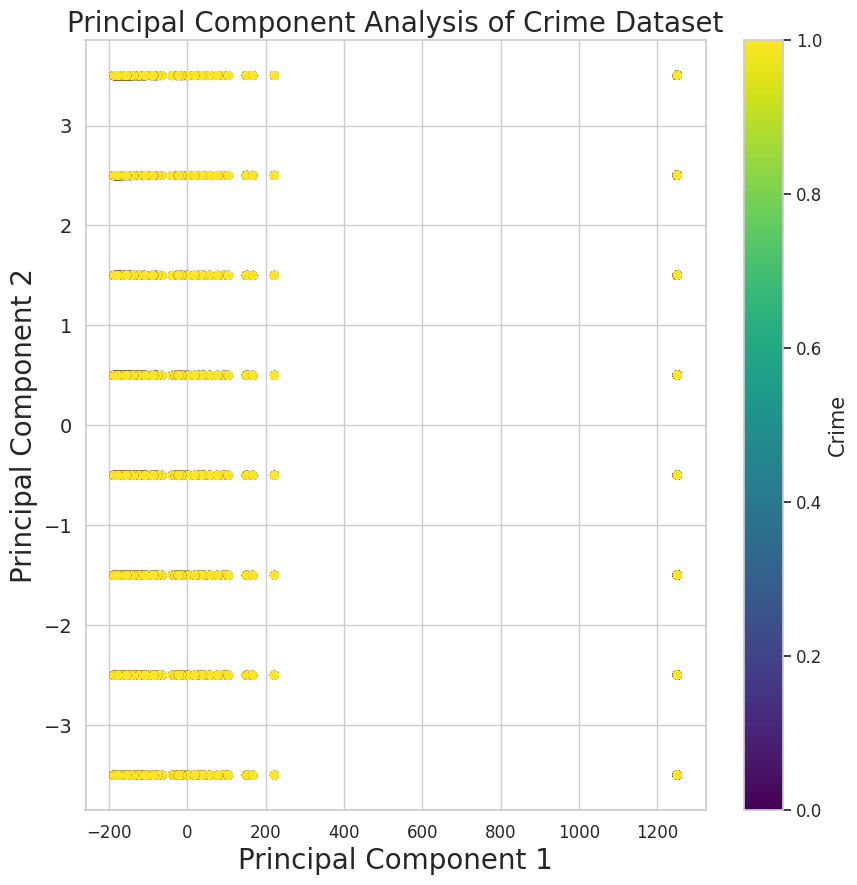

In [33]:
plt.figure()
plt.figure(figsize=(10, 10))

plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel("Principal Component 1", fontsize=20)
plt.ylabel("Principal Component 2", fontsize=20)
plt.title("Principal Component Analysis of Crime Dataset", fontsize=20)

sc = plt.scatter(
    pca_df['principal component 1'],
    pca_df['principal component 2'],
    c=df['category'],
    cmap='viridis',
    s=30
)


cbar = plt.colorbar(sc)
cbar.set_label('Crime', fontsize=15)
cbar.ax.tick_params(labelsize=12)

plt.show()

The visualization above illustrates the distribution of data points across the two principal components for the crime dataset. Principal Component 1 dominates with a large range of values, while Principal Component 2 shows much smaller variations. The vertical bands in the plot indicate clusters or patterns in the data, suggesting that the variability in the dataset is mostly aligned along the first principal component, with the colorbar representing crime categories contributing to the analysis.

### 7.2 Model Training using PCA

Now we fit the PCA on our training and testing set, and evaluate the model performance again.

In [34]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

We will begin by evaluating the baseline model performance, this time we would train on the PCA dataset.

In [43]:
# Initialize models with default parameters
lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)
knn_model = KNeighborsRegressor()
catboost_model = CatBoostRegressor(silent=True, random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42)
lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
svr_model = SVR()
dt_model = DecisionTreeRegressor(random_state=42)

models = [
    ('Linear Regression', lr_model),
    ('Random Forest', rf_model),
    ('KNN', knn_model),
    ('CatBoost', catboost_model),
    ('Gradient Boosting', gb_model),
    ('XGBoost', xgb_model),
    ('LightGBM', lgb_model),
    ('SVR', svr_model),
    ('Decision Tree', dt_model)
]

results = []

for name, model in models:
    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_test_pca)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    })

    print(f"{name} - MAE: {mae:.2f}")
    print(f"{name} - MSE: {mse:.2f}")
    print(f"{name} - RMSE: {rmse:.2f}")
    print(f"{name} - R²: {r2:.2f}\n")

Linear Regression - MAE: 401.47
Linear Regression - MSE: 628031.24
Linear Regression - RMSE: 792.48
Linear Regression - R²: 0.07

Random Forest - MAE: 79.10
Random Forest - MSE: 157463.28
Random Forest - RMSE: 396.82
Random Forest - R²: 0.77

KNN - MAE: 81.03
KNN - MSE: 164765.79
KNN - RMSE: 405.91
KNN - R²: 0.76

CatBoost - MAE: 97.83
CatBoost - MSE: 241094.21
CatBoost - RMSE: 491.01
CatBoost - R²: 0.64

Gradient Boosting - MAE: 110.46
Gradient Boosting - MSE: 230992.39
Gradient Boosting - RMSE: 480.62
Gradient Boosting - R²: 0.66

XGBoost - MAE: 94.17
XGBoost - MSE: 240135.41
XGBoost - RMSE: 490.04
XGBoost - R²: 0.64

LightGBM - MAE: 119.32
LightGBM - MSE: 350160.04
LightGBM - RMSE: 591.74
LightGBM - R²: 0.48

SVR - MAE: 134.16
SVR - MSE: 650283.62
SVR - RMSE: 806.40
SVR - R²: 0.03

Decision Tree - MAE: 78.66
Decision Tree - MSE: 183797.37
Decision Tree - RMSE: 428.72
Decision Tree - R²: 0.73



Overall we can see that training PCA leads to higher MAE compare to the model training without PCA. Random Forest and Decision Tree Regressor contains a lower MAE compared to the other models, meanwhile we also notice that this time KNN has a lower MAE. Next, let's train and fit PCA on Neural Network. We will train the neural network model for 250 epochs, as this number of epochs yielded the lowest MAE in previous experiments.

In [46]:
def build_nn_model(input_dim):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

print(f"\nTraining Neural Network with 250 epochs...")

nn_model = build_nn_model(X_train_pca.shape[1])

nn_model.fit(X_train_pca, y_train, epochs=250, batch_size=32, verbose=0)

y_pred_nn = nn_model.predict(X_test_pca).flatten()
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn)

print(f"Neural Network - MAE: {mae_nn:.2f}")
print(f"Neural Network - MSE: {mse_nn:.2f}")
print(f"Neural Network - RMSE: {rmse_nn:.2f}")
print(f"Neural Network - R²: {r2_nn:.2f}")


Training Neural Network with 250 epochs...
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network - MAE: 134.13
Neural Network - MSE: 381985.80
Neural Network - RMSE: 618.05
Neural Network - R²: 0.43


The neural network achieves the following evaluation metrics: an MAE of 134, an MSE of 381985.80, an RMSE of 618, and an $R^2$ score of 0.43. Let's take a look at the summary of the neural network model. 

In [47]:
nn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1024)           │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,127,173 (19.56 MB)

 Trainable params: 1,709,057 (6.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,418,116 (13.04 MB)

Now, we will append the result metrics from neural networks to our results list for evaluation later.

In [49]:
results.append({
    'Model': 'Neural Network',
    'MAE': mae_nn,
    'MSE': mse_nn,
    'RMSE': rmse_nn,
    'R²': r2_nn
})

## 8.0 Model Evaluations and Predictions

### 8.1 Model Evaluations

Following on,  we will evaluate the models trained earlier by conducting a straightforward comparison of all 10 models. This comparison focuses on key evaluation metrics such as MAE, MSE, RMSE, and $R^2$, which are visualized in the plots below. Model evaluation is crucial as it provides a clear understanding of each model's performance, enabling us to identify the most accurate and reliable model for predicting outcomes. By comparing these metrics, we can ensure that the selected model aligns with the goals of the task and effectively generalizes to unseen data.

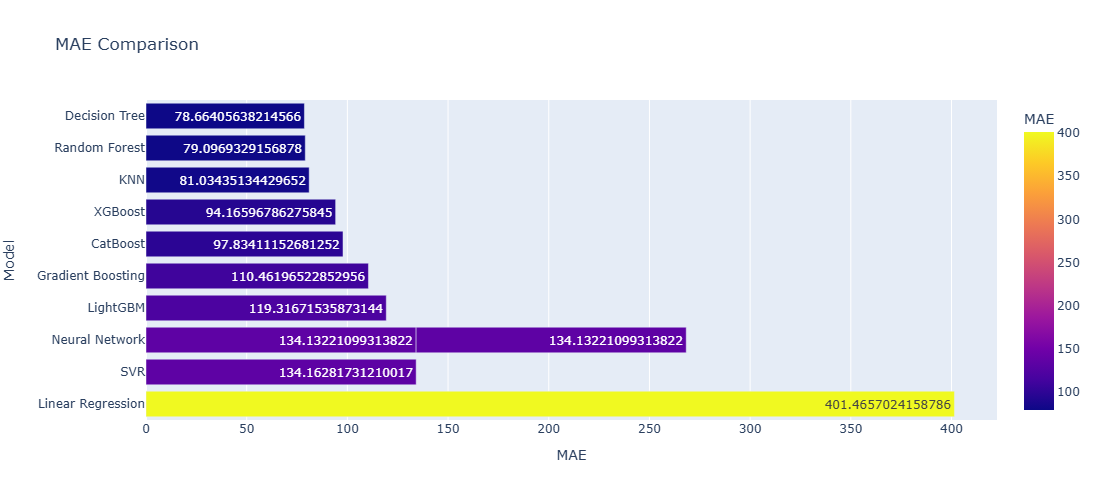

In [50]:
results_df = pd.DataFrame(results)
MAE_sorted = results_df.sort_values(by='MAE', ascending=False)

fig = px.bar(data_frame=MAE_sorted, x='MAE', y='Model', color='MAE',
             title='MAE Comparison', text='MAE')
fig.update_layout(width=600, height=500)
fig.show()

From the visualization above, we observe that the Decision Tree Regressor achieves the lowest MAE among all the models at 78.66, indicating its ability to minimize average errors in predicting the number of crimes. In contrast, Linear Regression and the SVR model perform the worst, suggesting they are less effective at providing accurate predictions compared to the other models. Next, let's take a look at the MSE comparisons of all trained models.

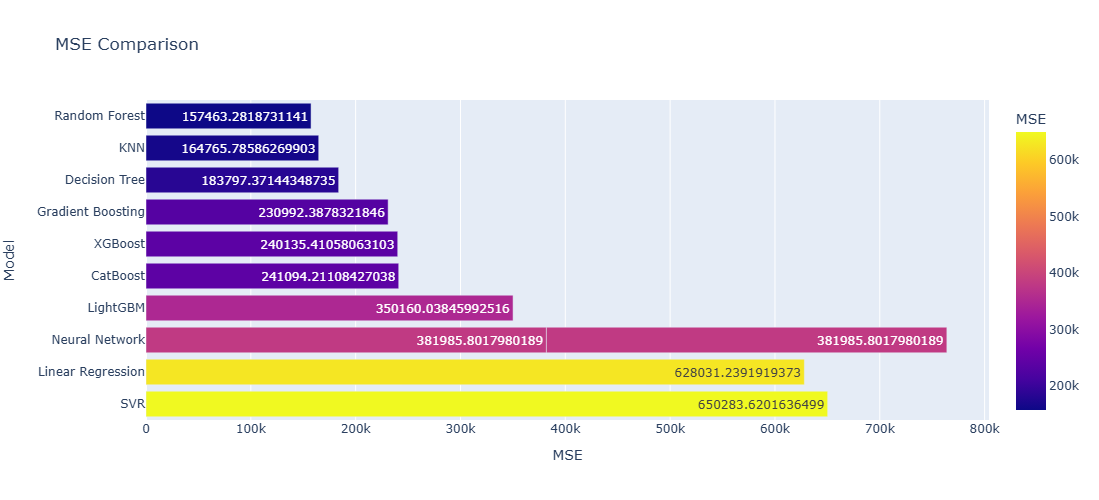

In [51]:
MAE_sorted = results_df.sort_values(by='MSE', ascending=False)

fig = px.bar(data_frame=MAE_sorted, x='MSE', y='Model', color='MSE',
             title='MSE Comparison', text='MSE')
fig.update_layout(width=600, height=500)
fig.show()

From the visualization above, we observe that the Random Forest Regressor achieves the lowest MSE among all the models at 157,463, indicating its superior ability to minimize prediction errors for the number of crimes. This is followed by KNN with an MSE of 164,765 and the Decision Tree Regressor at 183,797, both of which show reasonably competitive performance compared to Random Forest.

In contrast, SVR significantly underperforms with an MSE of 650,283, reflecting its struggle to capture the underlying patterns in the data and leading to substantially higher prediction errors. Next, we examine the model comparisons based on RMSE metrics.

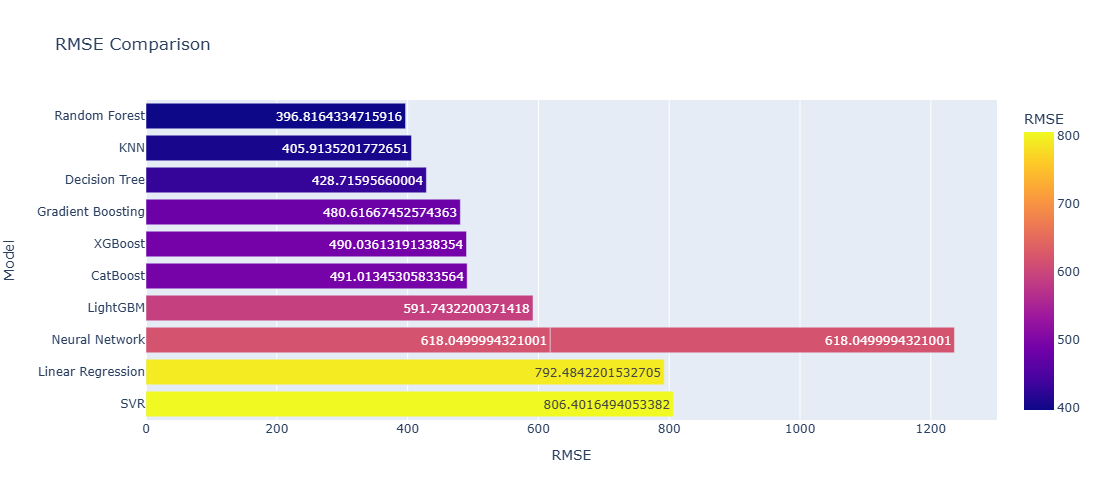

In [52]:
RMSE_sorted = results_df.sort_values(by='RMSE', ascending=False)

fig = px.bar(data_frame=MAE_sorted, x='RMSE', y='Model', color='RMSE',
             title='RMSE Comparison', text='RMSE')
fig.update_layout(width=600, height=500)
fig.show()

From the visualization above, we observe that the Random Forest Regressor achieves the lowest RMSE (Root Mean Squared Error) among all the models at 396.82, indicating it provides the most accurate predictions for the target variable, which is the number of crimes. This performance suggests that the Random Forest model effectively captures the underlying patterns and reduces the error in predictions compared to other models. KNN follows closely with an RMSE of 405.91, demonstrating a reasonably good performance, while the Decision Tree model, with an RMSE of 428.72, shows a moderate ability to predict the number of crimes, highlighting its inability to fit the data effectively and resulting in larger prediction errors. In contrast, SVR performs the worst, with a RMSE of 806.4. Next we will look into $R^2$ evaluation metrics for all the models.

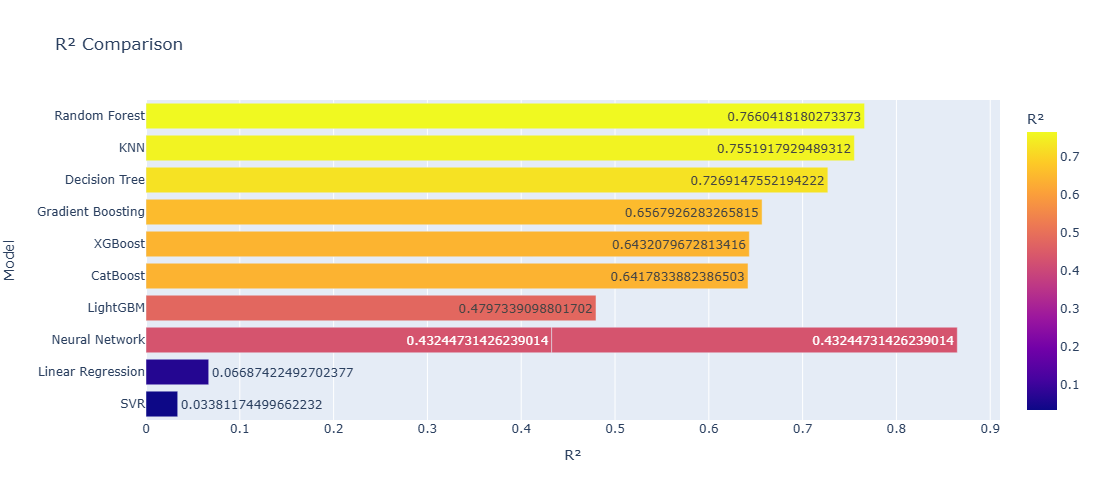

In [53]:
RMSE_sorted = results_df.sort_values(by='R²', ascending=False)

fig = px.bar(data_frame=MAE_sorted, x='R²', y='Model', color='R²',
             title='R² Comparison', text='R²')
fig.update_layout(width=600, height=500)
fig.show()

From the visualization above, we observe that the Random Forest Regressor demonstrates the best performance in terms of the coefficient of determination ($R^2$), indicating it is the most effective model in explaining the variability in the target variable, which is the number of crimes.  K-Nearest Neighbors (KNN) model ranks second, achieving a slightly lower $R^2$ score than Random Forest but still performing well in capturing the patterns in the data. The Decision Tree model comes third, with a moderate $R^2$ value, showing it explains the variability in the target variable to some extent but is less effective than the top two models.

In contrast, the Support Vector Regressor (SVR) records the lowest $R^2$ score among the evaluated models. This indicates that SVR struggles to capture the underlying relationships in the data and explains the variability in the number of crimes the least effectively. These results highlight the varying capabilities of the models in predicting the number of crimes based on the given features.

### 8.2 Learning Curves

Following on, we will evaluate the performance of the models by plotting the learning curves between the training score and the cross validation scores.
- The wider the gap between the training score and the cross validation score, the more likely our model is overfitting (high variance).
- If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)

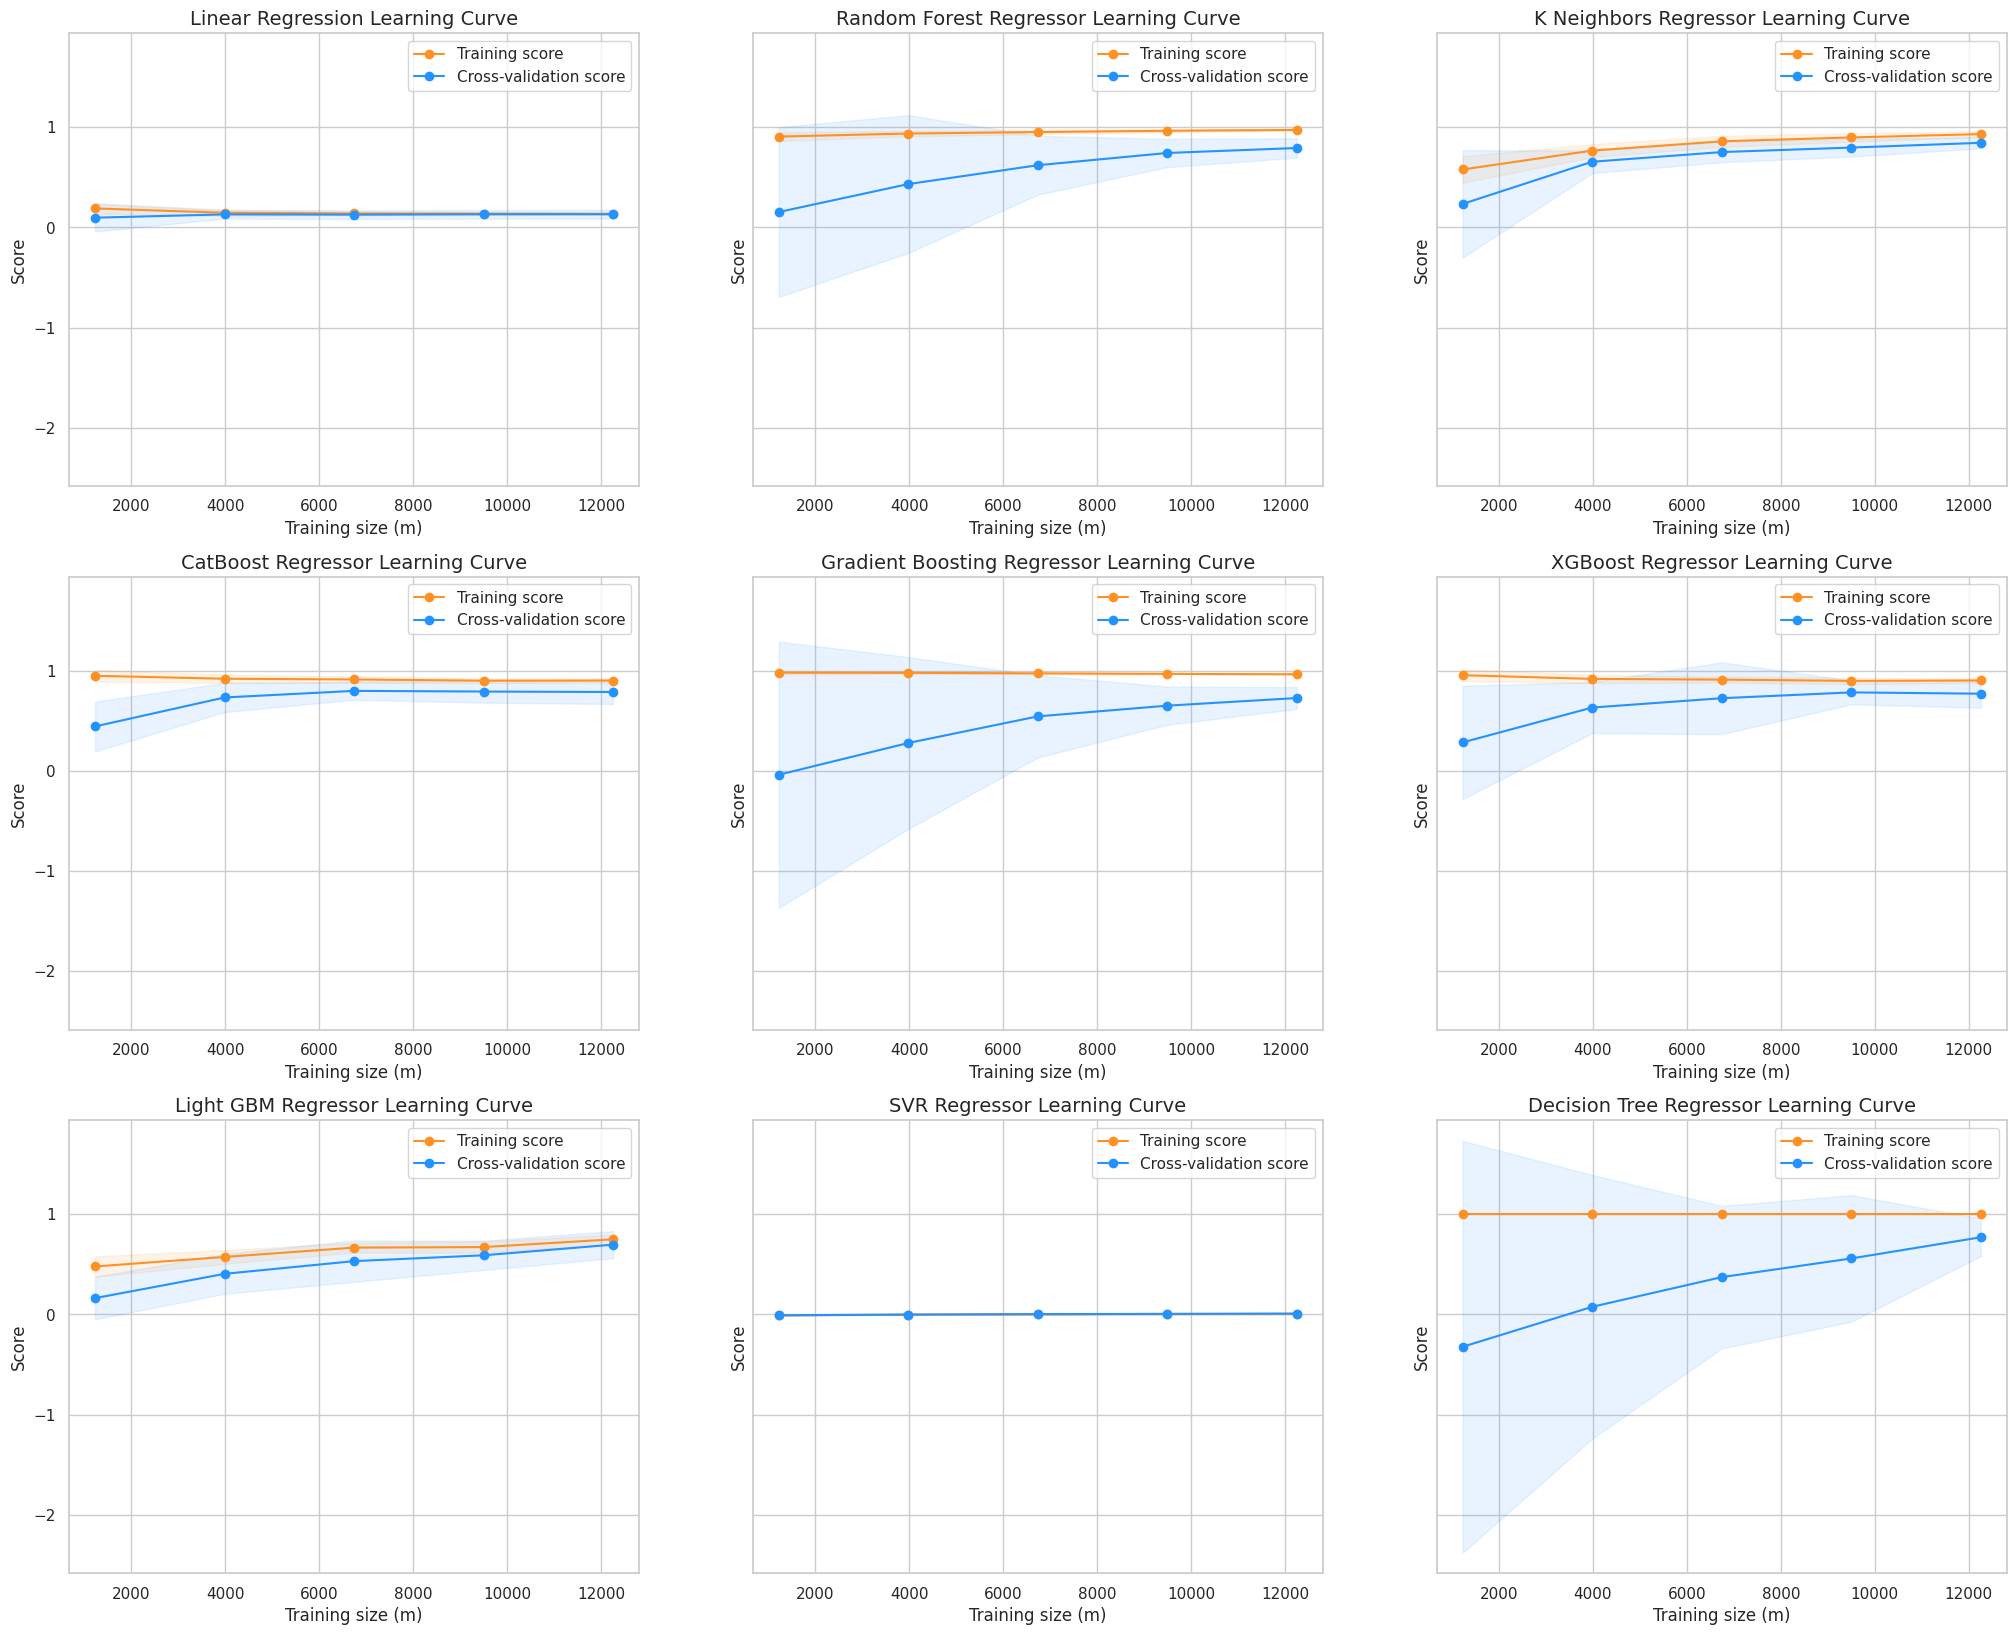

In [68]:
def plot_learning_curve(estimator, X, y, ax, model, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax.set_title(f"{model} Learning Curve", fontsize=14)
    ax.set_xlabel('Training size (m)')
    ax.set_ylabel('Score')
    ax.grid(True)
    ax.legend(loc="best")
    # return plt

cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=42)
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(25,20), sharey=True)

plot_learning_curve(lr_model, X_train_pca, y_train, ax1, "Linear Regression", cv=cv, n_jobs=4)
plot_learning_curve(rf_model, X_train_pca, y_train, ax2, "Random Forest Regressor", cv=cv, n_jobs=4)
plot_learning_curve(knn_model, X_train_pca, y_train, ax3, "K Neighbors Regressor", cv=cv, n_jobs=4)
plot_learning_curve(catboost_model, X_train_pca, y_train, ax4, "CatBoost Regressor", cv=cv, n_jobs=4)
plot_learning_curve(gb_model, X_train_pca, y_train, ax5, "Gradient Boosting Regressor", cv=cv, n_jobs=4)
plot_learning_curve(xgb_model, X_train_pca, y_train, ax6, "XGBoost Regressor", cv=cv, n_jobs=4)
plot_learning_curve(lgb_model, X_train_pca, y_train, ax7, "Light GBM Regressor", cv=cv, n_jobs=4)
plot_learning_curve(svr_model, X_train_pca, y_train, ax8, "SVR Regressor", cv=cv, n_jobs=4)
plot_learning_curve(dt_model, X_train_pca, y_train, ax9, "Decision Tree Regressor", cv=cv, n_jobs=4)
plt.show()

Based on the visualization of the learning curves, the Random Forest Regressor demonstrates the best performance among all the models. This is evident from the small gap between its training score and cross-validation score, indicating that the model generalizes well to unseen data. It achieves high accuracy on both the training and validation sets, effectively balancing bias and variance.

The second-best performers are the K Neighbors Regressor and Decision Tree Regressor. Their learning curves reveal slightly larger gaps between the training and cross-validation scores compared to the Random Forest Regressor. However, these gaps are still reasonable, suggesting these models generalize relatively well, albeit with slightly higher variance or overfitting tendencies.

In contrast, the Linear Regression and SVR Regressor perform the worst. Their learning curves display no significant gap between the training and cross-validation scores, with both scores being relatively low. This pattern strongly suggests that these models are underfitting the data, as they fail to capture the underlying relationships effectively. Consequently, their poor performance highlights a lack of complexity required to model the data appropriately.

### 8.3 Feature Importance

Next, we will plot the feature importance on the top 3 regressor which performs the best in MAE, MSE, RMSE and $R^2$, and they are Random Forest Regressor, Decision Tree Regressor and K Neighbors Regressor. However, since KNN doesnt support feature importance, we would utilise Gradient Boosting as our last model instead. Feature importance helps us understand which variables contribute most to the model's predictions, enabling better interpretation and potential optimization of the dataset.

In [54]:
def plot_feature_importances(model, model_name, color_scale='Reds', dataframe=None):
    # Extracting feature importances and sorting them
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = dataframe.columns

    feature_importances = pd.DataFrame({
        'Feature': feature_names[indices],
        'Importance': importances[indices]
    })

    # Plotting the feature importances
    fig = px.bar(feature_importances.sort_values('Importance', ascending=True), 
                 x='Importance', 
                 y='Feature',
                 title=f"Feature Importances in {model_name}",
                 labels={'Importance': 'Importance', 'Feature': 'Feature'},
                 height=1400,
                 color='Importance',
                 color_continuous_scale=color_scale)

    fig.update_layout(xaxis_title='Importance', yaxis_title='Feature')

    return fig

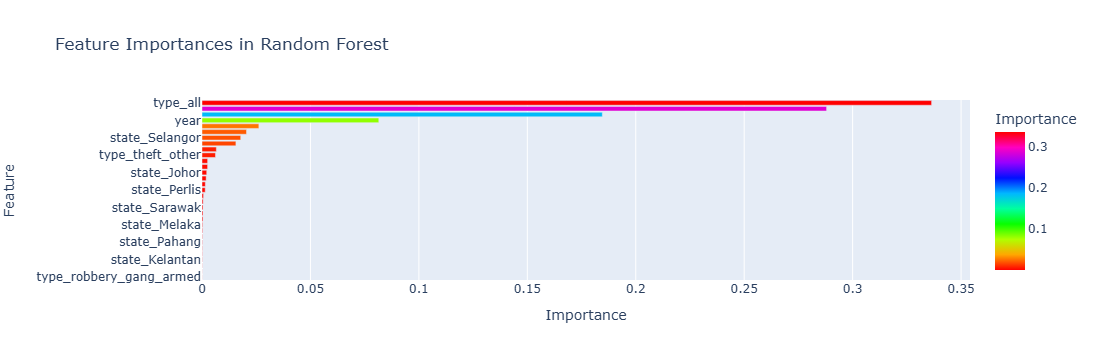

In [60]:
model_name = 'Random Forest'
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
fig = plot_feature_importances(rf_model, model_name, 'HSV', X_train)
fig.show()

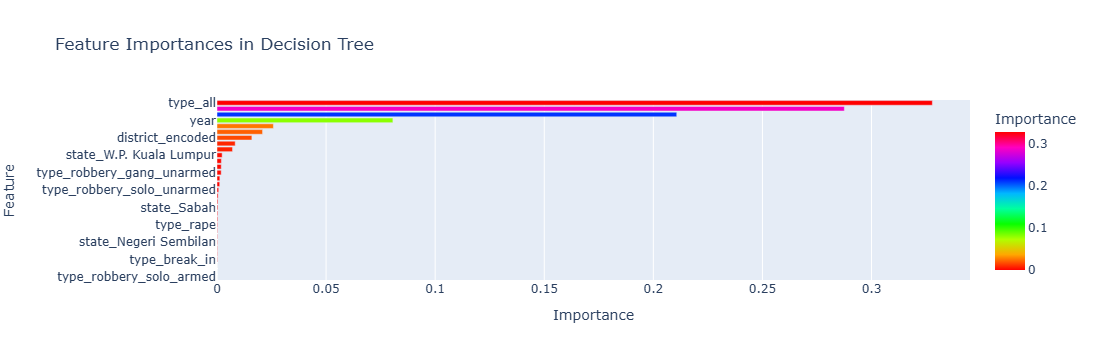

In [61]:
model_name = 'Decision Tree'
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
fig = plot_feature_importances(dt_model, model_name, 'HSV', X_train)
fig.show()

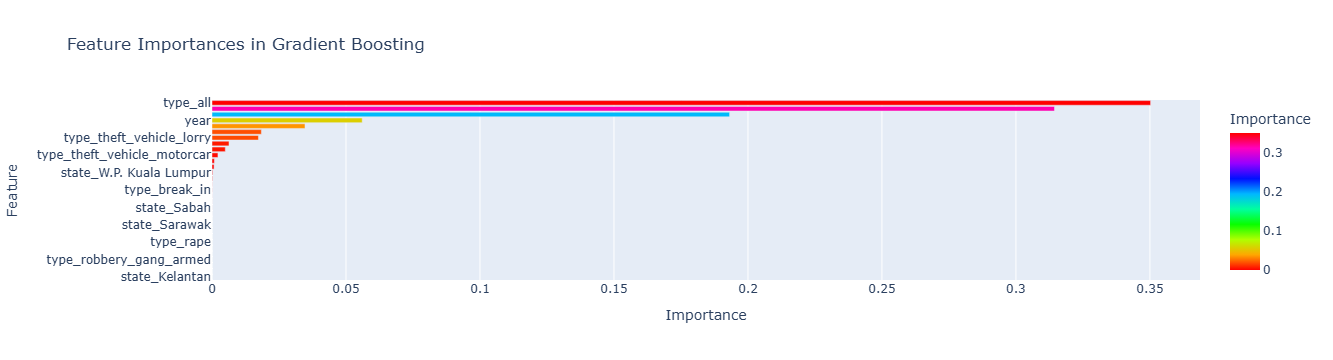

In [63]:
model_name = 'Gradient Boosting'
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
fig = plot_feature_importances(gb_model, model_name, 'HSV', X_train)
fig.show()

As we notice from the feature importance visualizations above, the feature type contributed the most to the model's decisions, followed by state (Malaysia) and category. This indicates that the model heavily relies on these variables to make accurate predictions, suggesting their strong influence on the target outcome. Understanding these key features can guide future improvements in the dataset, feature engineering, or even policy decisions depending on the application context.

### 8.4 Model Predictions

Next, we will utilise our best model, which is Random Forest Regressor, and predict on our result and save to a csv file.

In [68]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rf_result = pd.DataFrame(X_test.index)
rf_result['Predictions'] = y_pred
rf_result.to_csv('result.csv', index=False)
rf_result

0  Predictions
0     14230         2.47
1      9347         0.00
2       344        50.76
3      1034         7.66
4      8608         7.08
...     ...          ...
3826  16128       922.32
3827   1593        11.06
3828   9097        10.77
3829   5933       399.06
3830    366         7.61

[3831 rows x 2 columns]

## 9 Conclusion

By identifying trends and patterns in crime occurrences, law enforcement agencies can deploy resources more efficiently, focusing on areas and times where crimes are most likely to occur. For instance, targeted policing strategies can be implemented in high-crime areas like Kuala Lumpur, Penang, and Johor Bahru during peak crime periods. This data-driven approach allows for proactive crime prevention rather than reactive responses, potentially reducing the overall crime rate and improving public safety. Additionally, the analysis can guide policymakers in allocating funds and manpower to areas with the greatest need, ensuring that limited resources are used optimally.

The predictive capabilities of our regression model also pave the way for a smarter and more efficient crime prevention system. By utilizing the model’s insights, local governments and law enforcement agencies can design tailored intervention programs for specific crime types, such as theft, burglary, and violent crimes, which are particularly prevalent in urban areas. Furthermore, the ability to identify potential crime hotspots empowers communities to collaborate with authorities in implementing preventive measures such as enhanced neighborhood watch programs or increased surveillance. By shifting towards a data-driven approach, Malaysia can adopt a more proactive stance in crime prevention, transforming urban centers into safer environments and fostering greater public trust in the efficiency of law enforcement efforts.

## 10. References
1. [Neural Network Regression Implementation and Visualization in Python](https://medium.com/@nandiniverma78988/neural-network-regression-implementation-and-visualization-in-python-d5893713ed79)
2. [Dealing with Imbalanced Datasets](https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets#Learning-Curves:)